In [2]:
import gensim.models
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import scipy.stats as stats
import shutil

from zipfile import ZipFile

## let us get the data

In [3]:
def get_patients_data(path_to_csv, columns=None, dropna=True):
    """
    gets a csv dataset into pandas keeping specified columns and dropping or keeping na's

    :param path_to_csv: str
    :param columns: list of str, columns to keep, None by default (keeps all)
    :param dropna: bool, whether to drop na's, True by default
    :return: pd.DataFrame
    """
    res = pd.read_csv(path_to_csv, index_col=0)
    if columns:
        columns = list(filter(lambda col: col in res, columns))
        if columns:
            res = res[columns]
    if dropna:
        res = res.dropna()
    return res

**let us turn ;-separated str into lists**

In [4]:
csv = "verbal fluency.csv"
animals = get_patients_data(csv, ['animals'])
animals['animals'] = animals['animals'].apply(lambda s: [x.strip() for x in s.strip().split(';')])
animals.head()

,animals
ID,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл..."
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме..."
3,"[собака, кошка, черепаха, слон, крокодил, обез..."
4,"[кошка, мышка, собака, тигр, лев, канарейка, с..."
5,"[лось, медведь, лиса, волк, корова, собака, ко..."


**let us add dummy POS-tags for the model**

In [5]:
def add_POS_tags(patient_word_list):
    """
    adds "POS tags" to words in a word list
    if single word is given, _NOUN tag is added
    if a bi-gram is given, _ADJ and _NOUN tags are added
    
    :param patient_word_list: list of str, words
    :return: list of str, words with POS tags
    """
    res = []
    for j, word in enumerate(patient_word_list):
        if word:
            if ' ' in word:
                first, second = word.split()
                first += '_ADJ'
                second += '_NOUN'
                res.append(first + ' ' + second)
            else:
                res.append(word+'_NOUN')
    return res

In [6]:
add_POS_tags(['жираф', 'морской свинка', ''])

['жираф_NOUN', 'морской_ADJ свинка_NOUN']

In [7]:
animals['animals_POS'] = animals['animals'].apply(add_POS_tags)
animals.head()

,animals,animals_POS
ID,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ..."
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме...","[собака_NOUN, кошка_NOUN, лошадь_NOUN, кролик_..."
3,"[собака, кошка, черепаха, слон, крокодил, обез...","[собака_NOUN, кошка_NOUN, черепаха_NOUN, слон_..."
4,"[кошка, мышка, собака, тигр, лев, канарейка, с...","[кошка_NOUN, мышка_NOUN, собака_NOUN, тигр_NOU..."
5,"[лось, медведь, лиса, волк, корова, собака, ко...","[лось_NOUN, медведь_NOUN, лиса_NOUN, волк_NOUN..."


## let us unzip the best model into a temporary directory and load it

In [8]:
model_zip_name = 'models/tayga_upos_skipgram_300_2_2019.zip'
with ZipFile(model_zip_name, 'r') as myzip:
    myzip.extractall('models/tmp')

In [9]:
model_path = 'models/tmp/model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [10]:
shutil.rmtree('models/tmp/')

In [11]:
model['слон_NOUN']

array([ 0.08601318, -0.6828482 , -0.22675529, -0.22827153, -0.01361705,
        0.24698313, -0.04402011, -0.2475504 ,  0.07414407, -0.27594137,
        0.1739021 , -0.00158702,  0.01958552,  0.03729556,  0.5432982 ,
        0.0611247 ,  0.14772898,  0.02181707,  0.20535886, -0.11394621,
       -0.17934537,  0.2540597 ,  0.19710991, -0.06129597, -0.5700048 ,
        0.00850122,  0.2670366 ,  0.3233264 , -0.03196438, -0.18470246,
        0.38322222, -0.02588548,  0.28374165, -0.19383   , -0.08458902,
        0.4244925 , -0.15542516,  0.19162974, -0.06713919, -0.20103349,
        0.06785759,  0.05808949,  0.03733297,  0.07999419, -0.10370225,
        0.06420214, -0.11548744,  0.00239497, -0.2272254 , -0.19429892,
       -0.15440041, -0.34388942, -0.31899017,  0.14440675, -0.00867636,
        0.24022427, -0.21015681, -0.36691037,  0.08985427, -0.0185655 ,
       -0.16598868,  0.10741134,  0.14276543, -0.22300471, -0.11224405,
       -0.05493741,  0.48073494,  0.1417331 , -0.2366079 , -0.10

**let us define a way of handling bi-grams**

In [12]:
def collocation_handler(model, word, collocation_function=None):
    """
    gets a vector of a word or a bigram using a function to combine two vectors in a colloctaion
    
    :param model: gensim.Word2Vec model
    :param word: str, word or bi-gram
    :param collocation_function: function to combine two word vectors, None by default (np.mean is used)
    :return word_vector: np.ndarray, word vector
    :return not_found: int, number of words that were absent in the model
    """
    not_found = 0
    if ' ' in word:
        if not collocation_function:
            collocation_function = lambda vec1, vec2: np.mean([vec1, vec2], axis=0)
        first, second = word.split()
        if first in model and second in model:
            first_vector = model[first]
            second_vector = model[second]
            word_vector = collocation_function(first_vector, second_vector)
        elif first in model and second not in model:
            word_vector = model[first]
            not_found = 1
        elif first not in model and second in model:
            word_vector = model[second]
            not_found = 1
        else:
            word_vector = None
            not_found = 2
    else:
        if word in model:
            word_vector = model[word]
        else:
            word_vector = None
            not_found = 1
    return word_vector, not_found

In [13]:
collocation_handler(model, 'морской_ADJ свинка_NOUN')

(array([-2.40569502e-01, -2.65819699e-01,  2.47903019e-02,  3.60203013e-02,
         2.68500924e-01,  3.60444307e-01, -1.26190349e-01,  2.53701117e-03,
        -3.17839533e-02,  1.25960782e-02,  1.35463476e-01, -1.68274075e-01,
        -1.90845385e-01,  7.88793340e-03, -9.61406678e-02, -1.11334942e-01,
         3.70166034e-01,  4.08405542e-01, -1.55779645e-01,  1.14374891e-01,
        -5.48553877e-02,  9.86299813e-02, -1.45992398e-01,  1.50981732e-02,
        -5.47238231e-01,  1.22930489e-01,  2.63999104e-01, -7.07200095e-02,
        -2.63602316e-01, -1.15159288e-01,  2.86967874e-01, -9.13257897e-03,
        -1.56521797e-02, -1.82685494e-01,  1.65465757e-01,  1.50530890e-01,
        -4.82448116e-02,  2.58174300e-01, -2.40019649e-01, -3.00360192e-02,
         1.40154660e-02, -1.70106724e-01, -8.29464346e-02, -1.76284164e-01,
         2.51417272e-02, -2.48923823e-01,  2.01466367e-01, -4.91439104e-01,
        -3.01076591e-01,  6.46086335e-02, -3.41826528e-02, -7.60434270e-02,
         2.8

In [14]:
collocation_handler(model, 'kiufuer')

(None, 1)

In [15]:
collocation_handler(model, 'kiufuer свинка_NOUN')

(array([-0.24443445, -0.5771195 , -0.13867165,  0.20017748,  0.3237785 ,
         0.2328046 , -0.34049097,  0.03349691,  0.12646833,  0.18448459,
         0.24623515, -0.12471765, -0.16479154, -0.07681715, -0.03212069,
        -0.08459495,  0.36097503,  0.38839626,  0.05949978,  0.05217168,
        -0.19348028,  0.09540386, -0.47699255, -0.12457881, -0.57800716,
         0.14449762,  0.3292182 ,  0.16089065, -0.32228065, -0.08594431,
         0.36661896, -0.03241307,  0.18824233, -0.22222158,  0.11502609,
         0.19788364,  0.01979579,  0.24609703, -0.21542795,  0.03033229,
         0.17665893,  0.07056163, -0.2209753 , -0.15497443, -0.08215433,
         0.0810919 ,  0.18020569, -0.45008856,  0.00310612, -0.07636507,
         0.19055578,  0.04309632,  0.04444195,  0.23624417, -0.43727016,
         0.24869345, -0.19005972, -0.06291488,  0.00923101, -0.08208547,
         0.0858584 ,  0.20341316, -0.181405  , -0.06822711,  0.05965808,
         0.12983981,  0.37337086,  0.48328945, -0.0

## let us compute cosine similarities of a list of words

In [16]:
oov_list = []

In [17]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [18]:
def get_cos_sim_list(model, patient_word_list, collocation_function=None, oov=True):
    """
    calculates pairwise cosine similarities of words or collocations in a word list

    cosine similarity for a word pair that has a collocation is calculated as
    cosine similarity between a word vector and an average of word vectors from the collocation

    :param model: gensim.word2vec model
    :param patient_word_list: list of strings, words produced by the patient
    :param collocation_function: function combining two word vectors in a collocation, optional default is mean
    :param oov: bool, optional (True by deafult), whether to add oov words to a global variable oov_list
    :return patient_cos_sim_list: list of float, pairwise cosine similarities
    :return not_found: int, number of words missing from the model vocabulary
    """
    patient_cos_sim_list = []
    not_found = 0
    for j, word in enumerate(patient_word_list):
        if j > 0:
            previous_word = patient_word_list[j - 1]
            word_vector, nf = collocation_handler(model, word, collocation_function)
            not_found += nf
            previous_word_vector, nf = collocation_handler(model, previous_word, collocation_function)
            not_found += nf
            if word_vector is None :
                if oov:
                    oov_list.append(word)
                else:
                    continue
            elif previous_word_vector is not None:
                patient_cos_sim_list.append(cos_sim(word_vector, previous_word_vector))
            else:
                continue
    not_found = math.ceil(not_found / 2)
    return patient_cos_sim_list, not_found

In [19]:
get_cos_sim_list(model, ['морской_ADJ свинка_NOUN', 'мышь_NOUN', 'уж_NOUN', 'жираф_NOUN'], oov=False)

([0.39405695, 0.33655587, 0.24216779], 0)

In [20]:
get_cos_sim_list(model, ['морской_ADJ свинка_NOUN', 'мышь_NOUN', 'уж_NOUN', 'kjgfeagf','жираф_NOUN'], oov=False)

([0.39405695, 0.33655587], 1)

In [21]:
cf = lambda vec1, vec2: vec1 + 2*vec2
get_cos_sim_list(model, ['морской_ADJ свинка_NOUN', 'мышь_NOUN', 'уж_NOUN', 'жираф_NOUN'], collocation_function=cf, oov=False)

([0.45510814, 0.33655587, 0.24216779], 0)

**let us apply the technique to the dataset**

In [22]:
animals['cos_sim_list'], animals['oov_words'] = zip(*animals['animals_POS'].map(lambda x: get_cos_sim_list(model, x)))
animals.head()

,animals,animals_POS,cos_sim_list,oov_words
ID,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме...","[собака_NOUN, кошка_NOUN, лошадь_NOUN, кролик_...","[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...",0
3,"[собака, кошка, черепаха, слон, крокодил, обез...","[собака_NOUN, кошка_NOUN, черепаха_NOUN, слон_...","[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...",1
4,"[кошка, мышка, собака, тигр, лев, канарейка, с...","[кошка_NOUN, мышка_NOUN, собака_NOUN, тигр_NOU...","[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...",0
5,"[лось, медведь, лиса, волк, корова, собака, ко...","[лось_NOUN, медведь_NOUN, лиса_NOUN, волк_NOUN...","[0.73176044, 0.653271, 0.73672754, 0.43279937,...",0


In [23]:
animals['mean_cos_sim'] = animals['cos_sim_list'].apply(np.mean)
animals.head()

,animals,animals_POS,cos_sim_list,oov_words,mean_cos_sim
ID,,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0,0.516028
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме...","[собака_NOUN, кошка_NOUN, лошадь_NOUN, кролик_...","[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...",0,0.596951
3,"[собака, кошка, черепаха, слон, крокодил, обез...","[собака_NOUN, кошка_NOUN, черепаха_NOUN, слон_...","[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...",1,0.609784
4,"[кошка, мышка, собака, тигр, лев, канарейка, с...","[кошка_NOUN, мышка_NOUN, собака_NOUN, тигр_NOU...","[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...",0,0.501028
5,"[лось, медведь, лиса, волк, корова, собака, ко...","[лось_NOUN, медведь_NOUN, лиса_NOUN, волк_NOUN...","[0.73176044, 0.653271, 0.73672754, 0.43279937,...",0,0.567047


In [24]:
flatten = lambda l: [item for sublist in l for item in sublist]
list_cos_sim_all = flatten(animals['cos_sim_list'].tolist())
median = np.median(list_cos_sim_all)
p25 = np.percentile(list_cos_sim_all, 25)
p75 = np.percentile(list_cos_sim_all, 75)
mean = np.mean(list_cos_sim_all)
print(f'mean: {mean}\n\n25th percentile: {p25}\nmedian: {median}\n75th percentile: {p75}')

mean: 0.5596878528594971

25th percentile: 0.46141517162323
median: 0.5547636151313782
75th percentile: 0.6713592410087585


## clustering methods (Kim et al 2019)
[Automatic Scoring of Semantic Fluency](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6532534/) <br>
Best performance:
- English: threshold median
- Korean: threshold median, sharp


The models in the paper were selected w2v by median threshold correlation with manual counts _(questionable decision!)_
- English: the best model was the skip-gram model with d = 300,w = 4 (ρ = 0.657)
- Korean: the best model was the CBOW model with d = 1000,w = 4 (ρ = 0.572)


inter-group similarity would not work well on a small sample (as it relies on random negative sampling)

<img src="kim2019.jpg">

In [25]:
ex_list = animals['cos_sim_list'].tolist()[0]

### threshold cutoff
cluster boundary
- median & 25th percentile in the whole dataset
- average cosine similarity of each participant

In [26]:
def threshold_cutoff(list_of_values, threshold):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param threshold: int or float, value that elements must exceed
    :return ids: list of int, ids where value in list_of_values is below threshold
    :return cluster_num: int, number of values below threshold + 1
    """
    if type(list_of_values) != np.ndarray:
        list_of_values = np.array(list_of_values)
    ids = list(np.where(list_of_values < threshold)[0])
    cluster_num = len(ids) + 1
    return ids, cluster_num

In [27]:
p10 = np.percentile(ex_list, 10)
print(p10)
threshold_cutoff(ex_list, p10)

0.3298159420490265


([16, 19, 20], 4)

### sharp change
cluster boudary - cosine similarity is half _(or some other factor!)_ the average distance in the current cluster

In [28]:
def sharp_change(list_of_values, factor):
    """
    finds ids of elements below a threshold and the number of them (+1)
    
    :param list_of_values: list of int or float
    :param factor: int or float, nonzero, sharpness of change
    :return ids: list of int, ids where value in list_of_values changes sharply 
                            (by a factor of factor param)
    :return cluster_num: int, number of sharp changes + 1
    """
    cluster = [list_of_values[0]]
    ids = []
    for i, value in enumerate(list_of_values):
        current_mean = np.mean(cluster)
        if value < current_mean/factor:
            ids.append(i)
            cluster = [value]
        else:
            cluster.append(value)
    cluster_num = len(ids) + 1
    return ids, cluster_num

In [29]:
ids, n = sharp_change(ex_list, 1.2)
print(ids)
print(np.array(ex_list)[ids], n)

[5, 15, 16]
[0.46906286 0.42121196 0.14248623] 4


**let us also define a function that divides a set of words into clusters by change-indicies**

In [30]:
def get_splits(some_list, *ids):
    """
    splits a list into sublists by ids
    
    :param wordlist: list to be split
    :param ids: *ids where splits should be
    :return: lsit of lists, ssplit bu ids
    """
    ids = (0,) + tuple(data+1 for data in ids) + (len(some_list)+1,)
    lists = []
    for start, end in zip(ids, ids[1:]):
        sub = some_list[start:end]
        if sub:
            lists.append(sub)
    return lists

In [31]:
get_splits(['1', '2', '3', '4', '5'], 0, 2)

[['1'], ['2', '3'], ['4', '5']]

In [32]:
get_splits(['1', '2', '3', '4', '5'], 1, 4)

[['1', '2'], ['3', '4', '5']]

In [33]:
def print_splitted(list_of_lists):
    """
    prints a list of lists splitting inner lists by , and outer by ||
    
    :param list_of_lists: list of lists
    """
    list_of_lists = [map(str, l) for l in list_of_lists]
    list_of_lists = [', '.join(l) for l in list_of_lists]
    print(' || '.join(list_of_lists))

In [34]:
print_splitted(get_splits([1, 2, 3, 4, 5], 1, 4))

1, 2 || 3, 4, 5


**let us try to split a real list and see the clusters**

In [35]:
print('sharp (factor=0.95)')
ex_animals = animals['animals'].tolist()[0]
ids, n = sharp_change(ex_list, 0.95)
print_splitted(get_splits(ex_animals, *ids))
print(n)

print()
print('25th percentile')
p30 = np.percentile(ex_list, 25)
ids, n = threshold_cutoff(ex_list, p30)
print_splitted(get_splits(ex_animals, *ids))
print(n)

print()
print('median')
ex_median = np.median(ex_list)
ids, n = threshold_cutoff(ex_list, ex_median)
print_splitted(get_splits(ex_animals, *ids))
print(n)

print()
print('mean')
ex_mean = np.mean(ex_list)
ids, n = threshold_cutoff(ex_list, ex_mean)
print_splitted(get_splits(ex_animals, *ids))
print(n)

sharp (factor=0.95)
слон || заяц, волк, олень || кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж, еж, колобок || удав, фазан, козел
10

30th percentile
слон, заяц, волк, олень, кенгуру, жираф, суслик, хомячок, кролик, пингвин, страус, носорог, крокодил, бурый медведь, белый медведь, панда || гризли || уж || еж || колобок || удав || фазан || козел
8

median
слон || заяц, волк, олень, кенгуру, жираф || суслик, хомячок, кролик, пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж || еж || колобок || удав || фазан || козел
12

mean
слон, заяц, волк, олень, кенгуру, жираф || суслик, хомячок, кролик, пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж || еж || колобок || удав || фазан || козел
11


### let us calculate number of clusters by these methods

In [36]:
animals['c_cut_median'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, median)[1])
animals['c_cut_mean'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, mean)[1])
animals['c_cut_p25'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[1])
animals['c_cut_mean_local'] = animals['cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[1])
animals['c_sharp_1.05'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[1])
animals['c_sharp_1.005'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.005)[1])
animals['c_sharp_1.00001'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 1.00001)[1])
animals['c_sharp_0.95'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[1])
animals['c_sharp_0.8'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[1])
animals['c_sharp_0.5'] = animals['cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[1])
animals.head()

,animals,animals_POS,cos_sim_list,oov_words,mean_cos_sim,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5
ID,,,,,,,,,,,,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0,0.516028,13,13,7,11,7,8,9,10,19,22
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме...","[собака_NOUN, кошка_NOUN, лошадь_NOUN, кролик_...","[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...",0,0.596951,7,8,5,8,6,8,8,9,11,17
3,"[собака, кошка, черепаха, слон, крокодил, обез...","[собака_NOUN, кошка_NOUN, черепаха_NOUN, слон_...","[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...",1,0.609784,4,4,1,6,3,4,4,5,7,8
4,"[кошка, мышка, собака, тигр, лев, канарейка, с...","[кошка_NOUN, мышка_NOUN, собака_NOUN, тигр_NOU...","[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...",0,0.501028,14,14,11,12,9,10,10,11,11,19
5,"[лось, медведь, лиса, волк, корова, собака, ко...","[лось_NOUN, медведь_NOUN, лиса_NOUN, волк_NOUN...","[0.73176044, 0.653271, 0.73672754, 0.43279937,...",0,0.567047,8,8,3,8,5,6,6,7,10,12


## let us compare different separation methods to manual tagging

In [37]:
def splits_to_ids(list_of_lists):
    """
    gets ids of elements after which the splits are made
    
    :param list_of_lists: list of lists
    :return: list of int, ids of splits
    """
    out = []
    if len(list_of_lists) == 1:  # if no splits, as only one inner list
        return out
    else:
        current = 0
        for i, l in enumerate(list_of_lists):
            length = len(l)
            new_split_id = current + length - 1
            out.append(new_split_id)
            current = new_split_id + 1
        return out[:-1]

let us check, that it works correctly

In [38]:
ex_animals = animals['animals'].tolist()[0]
ids, n = sharp_change(ex_list, 1.005)
print(ids)
print(splits_to_ids(get_splits(ex_animals, *ids)))

[3, 5, 12, 14, 15, 16, 19]
[3, 5, 12, 14, 15, 16, 19]


**first, let us get out the manual tagging**

(Причесания разметчика:
Есть случаи, когда они переходят по ассоциации, так что слова относятся к разным кластерам, но связаны. Например утка-лебедь-рак-щука. Я размечала это как один кластер.)

In [39]:
with open('clustered.txt', 'r', encoding='utf-8') as f:
    lines = [l.strip() for l in f.readlines()]
    lines = [l for l in lines if l and not l.startswith('36')]  # 36 - пустая строка

lines[0]

'1 слон; заяц, волк, олень; кенгуру, жираф; суслик, хомячок, кролик; пингвин, страус; носорог, крокодил; бурый медведь, белый медведь, панда, гризли; уж, еж; колобок; удав; фазан; козел'

**let us drop out of vocabulary words** <br>
let us strip them of POS-tags

In [40]:
oov_list

['альпака_NOUN',
 'трубкозуб_NOUN',
 'фламинго_NOUN',
 'вомбат_NOUN',
 'россомаха_NOUN',
 'собака-динго_NOUN']

In [41]:
def remove_POS_tags(word_list):
    """
    removes "POS tags" to words in a word list
    if single word is given, _NOUN tag is added
    if a bi-gram is given, _ADJ and _NOUN tags are added
    
    :param word_list: list of str, words
    :return: list of str, words with POS tags
    """
    res = []
    for j, word in enumerate(word_list):
        if word:
            if ' ' in word:
                first, second = word.split()
                first = first.split('_')[0]
                second = second.split('_')[0]
                res.append(first + ' ' + second)
            else:
                res.append(word.split('_')[0])
    return res

In [42]:
oov_list = remove_POS_tags(oov_list)
oov_list

['альпака', 'трубкозуб', 'фламинго', 'вомбат', 'россомаха', 'собака-динго']

In [43]:
lines = [l.split(' ', 1) for l in lines]   # separate ids
lines = [[int(l[0]), l[1].split(';')] for l in lines]  # split clusters (by ;)
lines = [[l[0], [c.split(',') for c in l[1]]] for l in lines]  # split inside clusters (by ,)\
lines = [[l[0], [[w.strip() for w in c if w not in oov_list] for c in l[1]]] for l in lines]  # strip words and remove oov words
correct_ids = dict([(l[0], splits_to_ids(l[1])) for l in lines])
lines = dict([tuple(el) for el in lines])
lines[1]

[['слон'],
 ['заяц', 'волк', 'олень'],
 ['кенгуру', 'жираф'],
 ['суслик', 'хомячок', 'кролик'],
 ['пингвин', 'страус'],
 ['носорог', 'крокодил'],
 ['бурый медведь', 'белый медведь', 'панда', 'гризли'],
 ['уж', 'еж'],
 ['колобок'],
 ['удав'],
 ['фазан'],
 ['козел']]

In [44]:
correct_ids[1]

[0, 3, 5, 8, 10, 12, 16, 18, 19, 20, 21]

let us add correct numbers of splits to animals dataframe

In [46]:
animals['correct_c_num'] = pd.Series(correct_ids).apply(len)
animals.head()

,animals,animals_POS,cos_sim_list,oov_words,mean_cos_sim,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5,correct_c_num
ID,,,,,,,,,,,,,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0,0.516028,13,13,7,11,7,8,9,10,19,22,11
2,"[собака, кошка, лошадь, кролик, заяц, волк, ме...","[собака_NOUN, кошка_NOUN, лошадь_NOUN, кролик_...","[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...",0,0.596951,7,8,5,8,6,8,8,9,11,17,6
3,"[собака, кошка, черепаха, слон, крокодил, обез...","[собака_NOUN, кошка_NOUN, черепаха_NOUN, слон_...","[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...",1,0.609784,4,4,1,6,3,4,4,5,7,8,4
4,"[кошка, мышка, собака, тигр, лев, канарейка, с...","[кошка_NOUN, мышка_NOUN, собака_NOUN, тигр_NOU...","[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...",0,0.501028,14,14,11,12,9,10,10,11,11,19,10
5,"[лось, медведь, лиса, волк, корова, собака, ко...","[лось_NOUN, медведь_NOUN, лиса_NOUN, волк_NOUN...","[0.73176044, 0.653271, 0.73672754, 0.43279937,...",0,0.567047,8,8,3,8,5,6,6,7,10,12,6


In [47]:
model_name = 'tayga_upos_skipgram_300_2_2019'
out = animals.drop(columns = ['animals', 'animals_POS', 'cos_sim_list'])
out.to_csv(model_name + '.csv', index = False)

### let us compare absolut number of splits

In [48]:
split_nums_df = animals.drop(columns = ['animals', 'animals_POS', 'cos_sim_list', 'oov_words', 'mean_cos_sim'])

**let us see average cluster numbres for each method**

In [49]:
split_nums_df.apply(np.mean)

c_cut_median         9.086957
c_cut_mean           9.260870
c_cut_p25            5.043478
c_cut_mean_local     9.173913
c_sharp_1.05         6.173913
c_sharp_1.005        6.913043
c_sharp_1.00001      7.043478
c_sharp_0.95         9.086957
c_sharp_0.8         12.586957
c_sharp_0.5         16.630435
correct_c_num        9.956522
dtype: float64

**let us chect the normality**

In [50]:
split_nums_df.apply(lambda l: stats.normaltest(l)[1])

c_cut_median        0.614469
c_cut_mean          0.430152
c_cut_p25           0.085242
c_cut_mean_local    0.100790
c_sharp_1.05        0.608577
c_sharp_1.005       0.204767
c_sharp_1.00001     0.165279
c_sharp_0.95        0.213181
c_sharp_0.8         0.090579
c_sharp_0.5         0.048409
correct_c_num       0.009746
dtype: float64

**if we take a p of 0.05, all split numbers, but correct partitioning and sharp change as proposed in the original paper (factor of 0.5), are normally distributed!**<br>
oh, well, let us use non-parametric correlations, like Spermans

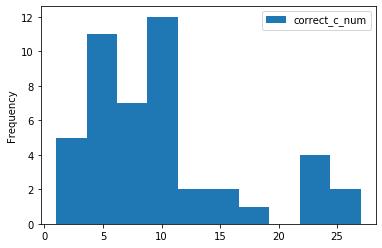

In [91]:
animals.plot(y='correct_c_num', kind='hist')

In [51]:
stats.spearmanr(split_nums_df['correct_c_num'], split_nums_df['c_cut_median'])

SpearmanrResult(correlation=0.6214436683884343, pvalue=4.0469163097652925e-06)

In [123]:
corrs = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)
for method in list(methods):
    r, p = list(stats.spearmanr(split_nums_df['correct_c_num'], split_nums_df[method]))
    corrs.loc[method] = [r, p, p<0.05]

corrs = pd.DataFrame([list(corrs.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
corrs.style.background_gradient(axis=0, cmap='Reds')  

,r,p,sig
c_cut_median,0.621444,4.04692e-06,True
c_cut_mean,0.623257,3.72209e-06,True
c_cut_p25,0.576507,2.75147e-05,True
c_cut_mean_local,0.680288,1.98531e-07,True
c_sharp_1.05,0.695671,8.03234e-08,True
c_sharp_1.00001,0.584366,2.0084e-05,True
c_sharp_0.95,0.692367,9.80138e-08,True
c_sharp_0.8,0.706165,4.19302e-08,True
c_sharp_0.5,0.731857,7.53034e-09,True


**as we can see, all methods of getting the _number_ of splits is ok at approximating manual calculation, the best being**
- cutting at the sharp changes with factors 0.5, 0.95, 0.8, 1.05; r$\approx$0.73 for 0.5, r$\approx$0.7 for others
- cutting at the mean cosine similarity within the list (r$\approx$0.7)

however, we know that the factor of 0.5 produces way too many splits, and the best at approximating not the ranks but the actual numbers are probably the ones with approximately the same mean split numbers (c_sharp_0.95 and c_cut_mean_local)

### let us compare split positioning

In [53]:
clustering = animals[['cos_sim_list']].copy()
clustering['correct_cut'] = pd.Series(correct_ids)
clustering['c_cut_median'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, median)[0])
clustering['c_cut_mean'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, mean)[0])
clustering['c_cut_p25'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, p25)[0])
clustering['c_cut_mean_local'] = clustering['cos_sim_list'].apply(lambda l: threshold_cutoff(l, np.mean(l))[0])
clustering['c_sharp_1.05'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 1.05)[0])
clustering['c_sharp_1.00001'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 1.00005)[0])
clustering['c_sharp_0.95'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 0.95)[0])
clustering['c_sharp_0.8'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 0.8)[0])
clustering['c_sharp_0.5'] = clustering['cos_sim_list'].apply(lambda l: sharp_change(l, 0.5)[0])
clustering['possible_splits'] = clustering['cos_sim_list'].apply(lambda l: len(l))
clustering.head()

,cos_sim_list,correct_cut,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5,possible_splits
ID,,,,,,,,,,,,
1,"[0.5170071, 0.67135924, 0.6578043, 0.56862366,...","[0, 3, 5, 8, 10, 12, 16, 18, 19, 20, 21]","[0, 5, 8, 12, 14, 15, 16, 17, 18, 19, 20, 21]","[0, 5, 8, 12, 14, 15, 16, 17, 18, 19, 20, 21]","[15, 16, 17, 19, 20, 21]","[5, 12, 14, 15, 16, 17, 18, 19, 20, 21]","[5, 12, 14, 15, 16, 19]","[3, 5, 8, 12, 14, 15, 16, 19]","[0, 3, 5, 8, 12, 14, 15, 16, 19]","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",22
2,"[0.7347066, 0.3801097, 0.35965052, 0.6953546, ...","[2, 6, 8, 12, 13, 14]","[1, 2, 9, 12, 14, 15]","[1, 2, 9, 12, 13, 14, 15]","[1, 2, 12, 14]","[1, 2, 9, 12, 13, 14, 15]","[1, 2, 9, 12, 14]","[1, 2, 6, 8, 9, 12, 14]","[0, 1, 2, 6, 8, 9, 12, 14]","[0, 1, 2, 6, 7, 8, 9, 12, 14, 15]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",16
3,"[0.7347066, 0.5041016, 0.6032447, 0.59325194, ...","[2, 5, 7, 8]","[1, 4, 5]","[1, 4, 5]",[],"[1, 2, 3, 4, 5]","[1, 5]","[1, 4, 5]","[0, 1, 4, 5]","[0, 1, 2, 3, 4, 5]","[0, 1, 2, 3, 4, 5, 6]",7
4,"[0.52633816, 0.3668137, 0.5475824, 0.8116844, ...","[2, 4, 7, 9, 11, 12, 15, 16, 18, 19]","[0, 1, 2, 4, 7, 9, 11, 12, 15, 16, 17, 18, 19]","[0, 1, 2, 4, 7, 9, 11, 12, 15, 16, 17, 18, 19]","[1, 4, 7, 9, 11, 12, 15, 16, 18, 19]","[1, 4, 7, 9, 11, 12, 15, 16, 17, 18, 19]","[1, 4, 7, 9, 11, 15, 16, 19]","[1, 4, 7, 9, 11, 15, 16, 18, 19]","[0, 1, 4, 7, 9, 11, 15, 16, 18, 19]","[0, 1, 4, 7, 9, 11, 15, 16, 18, 19]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15,...",20
5,"[0.73176044, 0.653271, 0.73672754, 0.43279937,...","[2, 5, 6, 7, 8, 9]","[3, 4, 6, 7, 8, 9, 10]","[3, 4, 6, 7, 8, 9, 10]","[3, 8]","[3, 4, 6, 7, 8, 9, 10]","[1, 3, 6, 8]","[1, 3, 6, 7, 8]","[0, 1, 3, 6, 7, 8]","[0, 1, 2, 3, 6, 7, 8, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",11


In [54]:
def get_metrics(correct_splits_list, predicted_splits_list, total_splits_num):
    """
    gets accuracy, precision, recall and f-measure of two lists of entries
    
    :param predicted_splits_list: list, correct members
    :param predicted_list: list, predicted members
    :param total_splits_num: int, maximum of possible splits
    :return a: float, accuracy
    :return p: float, precision
    :return r: float, recall
    :return f1: float, f1-measure
    """
    cor = set(correct_splits_list)
    pred = set(predicted_splits_list)
    tp = len(cor.intersection(pred))
    tn = total_splits_num - len(cor)
    fp = len(pred) - tp
    fn = len(cor) - tp
    a = (tp + tn) / total_splits_num
    if not pred:
        p = 0
    else:
        p = tp / len(pred)
    if not cor:
        r = 0
    else:
        r = tp / len(cor)
    if not p + r:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    return a, p, r, f1

In [55]:
get_metrics([0,1], range(10), 10)

(1.0, 0.2, 1.0, 0.33333333333333337)

In [56]:
id27 = clustering.loc[27]
get_metrics(id27['correct_cut'], id27['c_cut_mean_local'], id27['possible_splits'])

(0.48, 1.0, 0.48, 0.6486486486486487)

In [57]:
def get_average_metrics(df, correct_col, predicted_col, total_length_col):
    """
    calculates average accuracy, precision, recall and f1-measure for a df with lists of entries
    
    :param df: pandas DataFrame, to search in
    :param correct_col: str, column name with lists of correct entries
    :param predicted_col: str, column name with lists of predicted entries
    :param total_length_col: str, column name with ints (numbers of posssible entries)
    :return a: float, mean accuracy
    :return p: float, mean precision
    :return r: float, mean recall
    :return f1: float, mean f1-measure
    """
    m = []
    for i in clustering.index:
         m.append(get_metrics(clustering.loc[i][correct_col], 
                                   clustering.loc[i][predicted_col], 
                                   clustering.loc[i][total_length_col]))
    return np.mean(m, axis=0)

In [58]:
methods = list(clustering.drop(['correct_cut', 'possible_splits', 'cos_sim_list'], axis=1))

In [59]:
metrics_df = pd.DataFrame(index=methods, columns=['accuracy', 'precision', 'recall', 'f1-measure'])

In [60]:
for method in methods:
    metrics_df.loc[method] = get_average_metrics(clustering, 'correct_cut', method, 'possible_splits')
metrics_df

,accuracy,precision,recall,f1-measure
c_cut_median,0.764904,0.735506,0.650322,0.650895
c_cut_mean,0.773509,0.733427,0.661191,0.657087
c_cut_p25,0.595463,0.804822,0.360821,0.455518
c_cut_mean_local,0.7762,0.741929,0.685759,0.671965
c_sharp_1.05,0.654006,0.771342,0.455681,0.543543
c_sharp_1.00001,0.682829,0.751812,0.518207,0.570662
c_sharp_0.95,0.767823,0.70666,0.656295,0.64037
c_sharp_0.8,0.871985,0.650207,0.81263,0.684797
c_sharp_0.5,0.969211,0.58447,0.952826,0.690515


In [61]:
df = pd.DataFrame([list(metrics_df.loc[metric]) for metric in methods], index = methods, columns = ['accuracy', 'precision', 'recall', 'f1-measure'])
df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure
c_cut_median,0.764904,0.735506,0.650322,0.650895
c_cut_mean,0.773509,0.733427,0.661191,0.657087
c_cut_p25,0.595463,0.804822,0.360821,0.455518
c_cut_mean_local,0.7762,0.741929,0.685759,0.671965
c_sharp_1.05,0.654006,0.771342,0.455681,0.543543
c_sharp_1.00001,0.682829,0.751812,0.518207,0.570662
c_sharp_0.95,0.767823,0.70666,0.656295,0.64037
c_sharp_0.8,0.871985,0.650207,0.81263,0.684797
c_sharp_0.5,0.969211,0.58447,0.952826,0.690515


as we can see, the best metrics for acpproximation of splits are:
- cutoff at the mean is the best at catching all correct values (but poor at not-catching incorrect splits - making too many splits)
- sharp chage metrics (1.5 to 0.95) are good at only catching correct values (but bad at identifying all splits - making too little splits)

as we care more about only identifying correct splits (precision), then on identifying all correct splits (recall), let us weight the f-measure

$${\displaystyle F_{\beta }=(1+\beta ^{2})\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\beta ^{2}\cdot \mathrm {precision} +\mathrm {recall} }}}$$

let us use $\beta = 0.5 $, ads the $F_{0.5}$ which puts more emphasis on precision than recall.

In [62]:
df['f-weighted'] = (1 + 0.25) * df['precision'] * df['recall'] / (0.25 * df['precision'] + df['recall'])
df.style.background_gradient(axis=0, cmap='Reds')

,accuracy,precision,recall,f1-measure,f-weighted
c_cut_median,0.764904,0.735506,0.650322,0.650895,0.716729
c_cut_mean,0.773509,0.733427,0.661191,0.657087,0.717744
c_cut_p25,0.595463,0.804822,0.360821,0.455518,0.64587
c_cut_mean_local,0.7762,0.741929,0.685759,0.671965,0.729971
c_sharp_1.05,0.654006,0.771342,0.455681,0.543543,0.677481
c_sharp_1.00001,0.682829,0.751812,0.518207,0.570662,0.689635
c_sharp_0.95,0.767823,0.70666,0.656295,0.64037,0.695978
c_sharp_0.8,0.871985,0.650207,0.81263,0.684797,0.677281
c_sharp_0.5,0.969211,0.58447,0.952826,0.690515,0.633448


now we see that for a more precision-oriented task, the best metrics (at least on this model) are:
- cutoff at the local mean
- sharp chage metrics (1.05 to 0.95) 
- cutoff at the mean

overall the metrics are good-ish (0.7 is not all that good), but tolerable

**the problems might be due to:**
- only one manual tagging (might be low inter-rater agreement, if we tried many)
- tagging non-semantic assosiations as one cluster (утка-лебедь-рак-щука)
- out of vocabulary issues
- lack of training for the specific purpose (poor representation of animal lexicon)

In [122]:
print('correct')
print_splitted(get_splits(animals['animals'].tolist()[0], *correct_ids[1]))
print('median')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_cut_median'].tolist()[0]))
print('local mean')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_cut_mean_local'].tolist()[0]))
print('sharp 0.8')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_sharp_0.8'].tolist()[0]))
print('sharp 1.00001')
print_splitted(get_splits(animals['animals'].tolist()[0], *clustering['c_sharp_1.00001'].tolist()[0]))

correct
слон || заяц, волк, олень || кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус || носорог, крокодил || бурый медведь, белый медведь, панда, гризли || уж, еж || колобок || удав || фазан || козел
median
слон || заяц, волк, олень, кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж || еж || колобок || удав || фазан || козел
local mean
слон, заяц, волк, олень, кенгуру, жираф || суслик, хомячок, кролик, пингвин, страус, носорог, крокодил || бурый медведь, белый медведь || панда || гризли || уж || еж || колобок || удав || фазан || козел
sharp 0.8
слон || заяц, волк || олень || кенгуру || жираф || суслик || хомячок || кролик || пингвин || страус || носорог || крокодил || бурый медведь, белый медведь || панда || гризли || уж, еж, колобок || удав || фазан || козел
sharp 1.00001
слон, заяц, волк, олень || кенгуру, жираф || суслик, хомячок, кролик || пингвин, страус, носорог, крокодил || бурый 

## let us correlate the personal information with manual tagging

In [63]:
personal = get_patients_data('personal.csv', columns=['Age', 'Education years', 'Gender', 'Handedness'], dropna=False)
personal['Age'] = personal['Age'].apply(int)
personal['Education years'] = personal['Education years'].apply(lambda s: float(s.replace(',', '.')) if type(s) != float else s)
personal['Gender'] = personal['Gender'].apply(lambda s: s.strip().lower())
personal['Handedness'] = personal['Handedness'].apply(lambda s: s.strip().lower())
personal.head()

,Age,Education years,Gender,Handedness
ID,,,,
1,55,14.0,m,right
2,75,13.0,f,right
3,36,15.0,m,right
4,20,14.0,f,right
5,44,13.0,f,right


**let us see means and standard deviations**

In [64]:
personal.drop(['Gender', 'Handedness'], axis=1).apply(np.mean)

Age                41.173913
Education years    14.944444
dtype: float64

In [65]:
personal['Education years'] = personal['Education years'].fillna(math.ceil(np.mean(personal['Education years'])))

In [66]:
personal.drop(['Gender', 'Handedness'], axis=1).apply(np.std)

Age                19.318052
Education years     2.485235
dtype: float64

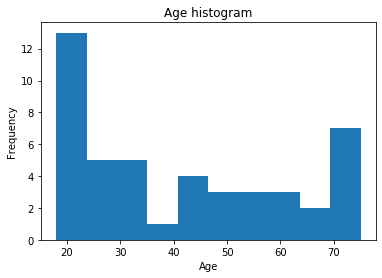

In [102]:
personal.plot(y='Age', kind='hist', legend=False)
plt.xlabel('Age')
plt.title('Age histogram');

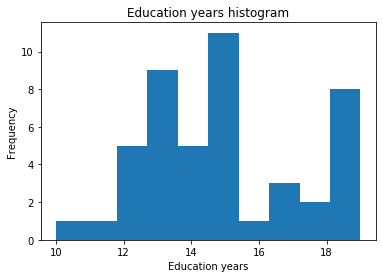

In [103]:
personal.plot(y='Education years', kind='hist', legend=False)
plt.xlabel('Education years')
plt.title('Education years histogram');

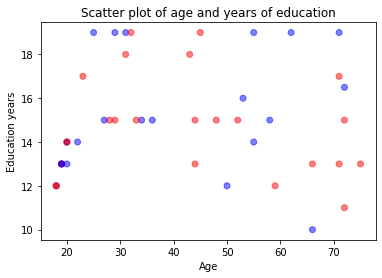

In [96]:
plt.scatter(personal['Age'], personal['Education years'], 
            c=['red' if x == 'f' else 'blue' for x in personal['Gender']], alpha=0.5)
plt.ylabel('Education years')
plt.xlabel('Age')
plt.title('Scatter plot of age and years of education');

**let us see how categorical data is distributed**

In [70]:
personal['Handedness'].value_counts()

right            44
left              1
left to right     1
Name: Handedness, dtype: int64

In [71]:
personal['Gender'].value_counts()

f    24
m    22
Name: Gender, dtype: int64

**let us chect the normality**

In [72]:
personal.drop(['Gender', 'Handedness'], axis=1).apply(lambda l: stats.normaltest(l)[1])

Age                0.000121
Education years    0.151853
dtype: float64

**ok, age is definetiley not normally distributed, and we have seen that**<br>
oh, well, let us use non-parametric correlations, like Spermans

In [73]:
stats.spearmanr(personal['Age'], personal['Education years'])

SpearmanrResult(correlation=0.18274584949194952, pvalue=0.22413703462329335)

good thing they are not correlated!

### let us correlate the number of clusters calculated by different methods

In [74]:
animals.head(1)

,animals,animals_POS,cos_sim_list,oov_words,mean_cos_sim,c_cut_median,c_cut_mean,c_cut_p25,c_cut_mean_local,c_sharp_1.05,c_sharp_1.005,c_sharp_1.00001,c_sharp_0.95,c_sharp_0.8,c_sharp_0.5,correct_c_num
ID,,,,,,,,,,,,,,,,
1,"[слон, заяц, волк, олень, кенгуру, жираф, сусл...","[слон_NOUN, заяц_NOUN, волк_NOUN, олень_NOUN, ...","[0.5170071, 0.67135924, 0.6578043, 0.56862366,...",0,0.516028,13,13,7,11,7,8,9,10,19,22,11


**Age**

In [75]:
stats.spearmanr(personal['Age'], animals['correct_c_num'])

SpearmanrResult(correlation=-0.36640024939461063, pvalue=0.012264973944660943)

**OK, this is good, as in theory (and in Kim et al 2019) older people produce fewer clusters**
And we also have the same result: p $\approx$ 0.01 (p<0.05), r $\approx$ -0.37

In [107]:
age_corr = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)

for method in methods:
    r, p = list(stats.spearmanr(personal['Age'], animals[method]))
    age_corr.loc[method] = [r, p, p<0.05]

age_corr = pd.DataFrame([list(age_corr.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
age_corr.style.background_gradient(axis=0, cmap='Reds')

,r,p,sig
c_cut_median,-0.32566,0.0272065,True
c_cut_mean,-0.352979,0.0161217,True
c_cut_p25,-0.307397,0.0376997,True
c_cut_mean_local,-0.400813,0.00577282,True
c_sharp_1.05,-0.302898,0.0407406,True
c_sharp_1.00001,-0.239174,0.10941,False
c_sharp_0.95,-0.324345,0.0278705,True
c_sharp_0.8,-0.306111,0.0385493,True
c_sharp_0.5,-0.380397,0.00911195,True


Ok, so all, but sharp change at 0.00001, do correlate negatively with age.<br>
The strongest are: 
- cutting at the local mean (r $\approx$ -0.4, p $\approx$ 0.006)
- sharp cahge at 0.5 (r $\approx$ -0.38, p $\approx$ 0.009)
- cutting at the mean (r $\approx$ -0.35, p $\approx$ 0.01)

let us note here, that metrics of cutting at the local mean and sharp cahge at 0.5 are more strongly correlated with age than manual splits!

There are other things we **do not** expect to be correlated with anything

In [77]:
stats.spearmanr(personal['Age'], animals['oov_words']) 

SpearmanrResult(correlation=-0.17280417475295348, pvalue=0.2507930608855757)

In [78]:
stats.spearmanr(personal['Age'], animals['mean_cos_sim']) 

SpearmanrResult(correlation=0.11749459706701747, pvalue=0.4367720721897411)

**Education years**

In [79]:
stats.spearmanr(personal['Education years'], animals['correct_c_num'])

SpearmanrResult(correlation=0.2239069242898038, pvalue=0.13468408080905914)

They are not correlated!

In [80]:
ed_corr = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)

for method in methods:
    r, p = list(stats.spearmanr(personal['Education years'], animals[method]))
    ed_corr.loc[method] = [r, p, p<0.05]

ed_corr = pd.DataFrame([list(ed_corr.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
ed_corr.style.background_gradient(axis=0, cmap='viridis')

,r,p,sig
c_cut_median,0.11334,0.453268,False
c_cut_mean,0.0879939,0.560897,False
c_cut_p25,0.0583261,0.700217,False
c_cut_mean_local,0.093892,0.534827,False
c_sharp_1.05,0.0498623,0.742095,False
c_sharp_1.00001,0.122229,0.418388,False
c_sharp_0.95,0.0967232,0.522526,False
c_sharp_0.8,0.201049,0.180317,False
c_sharp_0.5,0.140029,0.353318,False


None of the metrics correlate with education, which is expected, since the manual splits did not.

The other things we **do not** expect to be correlated with anything

In [81]:
stats.spearmanr(personal['Education years'], animals['oov_words']) 

SpearmanrResult(correlation=0.07153684847087048, pvalue=0.6366127635943083)

In [82]:
stats.spearmanr(personal['Education years'], animals['mean_cos_sim']) 

SpearmanrResult(correlation=-0.09505452716683865, pvalue=0.5297588044343581)

**Gender**

In [83]:
gender = personal['Gender'].apply(lambda g: 1 if g == 'f' else 0)

In [84]:
stats.spearmanr(gender, animals['correct_c_num'])

SpearmanrResult(correlation=-0.09540003308122362, pvalue=0.5282571388971329)

gender should not correelate on the metrics, as it does not on the manual splits

In [85]:
g_corr = pd.DataFrame(columns=['r', 'p', 'sig'], index=methods)

for method in methods:
    r, p = list(stats.spearmanr(gender, animals[method]))
    g_corr.loc[method] = [r, p, p<0.05]

g_corr = pd.DataFrame([list(g_corr.loc[metric]) for metric in methods], columns=['r', 'p', 'sig'], index=methods)
g_corr.style.background_gradient(axis=0, cmap='viridis')

,r,p,sig
c_cut_median,0.0954178,0.52818,False
c_cut_mean,0.10035,0.506975,False
c_cut_p25,0.150292,0.318786,False
c_cut_mean_local,-0.0263903,0.861793,False
c_sharp_1.05,0.0231298,0.878732,False
c_sharp_1.00001,-0.0263969,0.861759,False
c_sharp_0.95,-0.0462119,0.760395,False
c_sharp_0.8,-0.0953704,0.528386,False
c_sharp_0.5,-0.110023,0.466683,False


None of the metrics correlate with gender which is expected, since the manual splits did not.

The other things we **do not** expect to be correlated with anything

In [86]:
stats.spearmanr(personal['Gender'], animals['oov_words']) 

SpearmanrResult(correlation=0.27529827717249056, pvalue=0.0640632456085686)

In [87]:
stats.spearmanr(personal['Gender'], animals['mean_cos_sim']) 

SpearmanrResult(correlation=0.20979660203964265, pvalue=0.1616990909554755)